In [1]:
import keras
keras.__version__
import PIL
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
#from keras.applications import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input, decode_predictions

Using TensorFlow backend.


In [3]:
import os, shutil

# The path to the directory where the original
# dataset was uncompressed
#original_dataset_dir = '/Users/fchollet/Downloads/kaggle_original_data'
original_dataset_dir = '/home/rutherford/Github/Audilab_Project/Tree_Species/My_Data/data/Mutero_Images/'

# The directory where we will
# store our smaller dataset
#base_dir = '/Users/fchollet/Downloads/cats_and_dogs_small'
base_dir = '/home/rutherford/Github/Audilab_Project/11.Tree_Species_Indetification/data/Mutero_Images/'

#os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
#os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
#os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
#os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'Acacia_abyssinica')
#os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'Acacia_kirkii')
#os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'Acacia_abyssinica')
#os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'Acacia_kirkii')
#os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'Acacia_abyssinica')
#os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'Acacia_kirkii')
#os.mkdir(test_dogs_dir)

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [4]:
print('total training Acacia_abyssinica images:', len(os.listdir(train_cats_dir)))

total training Acacia_abyssinica images: 294


In [5]:
train_cats_dir

'/home/rutherford/Github/Audilab_Project/11.Tree_Species_Indetification/data/Mutero_Images/train/Acacia_abyssinica'

In [6]:
print('total training Acacia_kirkii images:', len(os.listdir(train_dogs_dir)))

total training Acacia_kirkii images: 232


In [7]:
print('total validation Acacia_abyssinica images:', len(os.listdir(validation_cats_dir)))

total validation Acacia_abyssinica images: 24


In [8]:
print('total validation Acacia_kirkii images:', len(os.listdir(validation_dogs_dir)))

total validation Acacia_kirkii images: 28


In [9]:
print('total test Acacia_abyssinica images:', len(os.listdir(test_cats_dir)))

total test Acacia_abyssinica images: 35


In [10]:
print('total test Acacia_kirkii images:', len(os.listdir(test_dogs_dir)))

total test Acacia_kirkii images: 28



So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of 
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate 
measure of success.

## Building our network

We've already built a small convnet for MNIST in the previous example, so you should be familiar with them. We will reuse the same 
general structure: our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one 
more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the 
feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a 
somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is 
decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a 
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [223]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(143, activation='softmax'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 128)       147584    
__________

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will 
use binary crossentropy as our loss (as a reminder, check out the table in Chapter 4, section 5 for a cheatsheet on what loss function to 
use in various situations).

In [14]:
from keras import models
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.metrics import categorical_accuracy

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              #metrics=[categorical_accuracy]
              metrics=['accuracy'])

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image 
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we 
will use here.

In [11]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(200, 200),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels #
        class_mode='categorical'
        )

test_generator = test_datagen.flow_from_directory(
        # This is the target directory
        test_dir,
        # All images will be resized to 150x150
        target_size=(200, 200),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels #
        class_mode='categorical'
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(200, 200),
        batch_size=20, 
        class_mode='categorical'
        )

Found 38777 images belonging to 143 classes.
Found 5157 images belonging to 143 classes.
Found 3571 images belonging to 143 classes.


In [12]:
classes = train_generator.class_indices
print(classes)

{'Acacia_abyssinica': 0, 'Acacia_kirkii': 1, 'Acacia_mearnsii': 2, 'Acacia_melanoxylon': 3, 'Acacia_nilotica': 4, 'Acacia_polyacantha': 5, 'Acacia_senegal': 6, 'Acacia_seyal': 7, 'Acacia_xanthophloea': 8, 'Afrocarpus_falcatus': 9, 'Afzelia_quanzensis': 10, 'Albizia_gummifera': 11, 'Albizia_lebbeck': 12, 'Allanblackia_floribunda': 13, 'Artocarpus_heterophyllus': 14, 'Azadirachta_indica': 15, 'Balanites_aegyptiaca': 16, 'Bersama_abyssinica': 17, 'Bischofia_javanica': 18, 'Brachylaena_huillensis': 19, 'Bridelia_micrantha': 20, 'Calodendron_capensis': 21, 'Calodendrum_capense': 22, 'Casimiroa_edulis': 23, 'Cassipourea_malosana': 24, 'Casuarina_cunninghamiana': 25, 'Casuarina_equisetifolia': 26, 'Catha_edulis': 27, 'Cathium_Keniensis': 28, 'Ceiba_pentandra': 29, 'Celtis_africana': 30, 'Chionanthus_battiscombei': 31, 'Clausena_anisat': 32, 'Clerodendrum_johnstonii': 33, 'Combretum_molle': 34, 'Cordia_africana': 35, 'Cordia_africana_Cordia': 36, 'Cotoneaster_Pannos': 37, 'Croton_macrostachyus

In [13]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [14]:
batch_size = 20

In [15]:
if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'

In [16]:
input_shape = (200, 200)

In [17]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [18]:
datagen_test = ImageDataGenerator(rescale=1./255)

In [19]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 38777 images belonging to 143 classes.


In [20]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 5157 images belonging to 143 classes.


In [21]:
generator_validation = datagen_test.flow_from_directory(directory=validation_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 3571 images belonging to 143 classes.


In [22]:
steps_test = generator_test.n / batch_size
steps_test

257.85

In [23]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [24]:
cls_train = generator_train.classes
cls_test = generator_test.classes

In [25]:
class_names = list(generator_train.class_indices.keys())
class_names

['Acacia_abyssinica',
 'Acacia_kirkii',
 'Acacia_mearnsii',
 'Acacia_melanoxylon',
 'Acacia_nilotica',
 'Acacia_polyacantha',
 'Acacia_senegal',
 'Acacia_seyal',
 'Acacia_xanthophloea',
 'Afrocarpus_falcatus',
 'Afzelia_quanzensis',
 'Albizia_gummifera',
 'Albizia_lebbeck',
 'Allanblackia_floribunda',
 'Artocarpus_heterophyllus',
 'Azadirachta_indica',
 'Balanites_aegyptiaca',
 'Bersama_abyssinica',
 'Bischofia_javanica',
 'Brachylaena_huillensis',
 'Bridelia_micrantha',
 'Calodendron_capensis',
 'Calodendrum_capense',
 'Casimiroa_edulis',
 'Cassipourea_malosana',
 'Casuarina_cunninghamiana',
 'Casuarina_equisetifolia',
 'Catha_edulis',
 'Cathium_Keniensis',
 'Ceiba_pentandra',
 'Celtis_africana',
 'Chionanthus_battiscombei',
 'Clausena_anisat',
 'Clerodendrum_johnstonii',
 'Combretum_molle',
 'Cordia_africana',
 'Cordia_africana_Cordia',
 'Cotoneaster_Pannos',
 'Croton_macrostachyus',
 'Croton_megalocarpus',
 'Cupressus_lusitanica',
 'Cussonia_Spicata',
 'Cussonia_holstii',
 'Diospyro

Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

In [26]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 200, 200, 3)
labels batch shape: (20, 143)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, 
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is 
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

In [31]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=500,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/500
100/100 [==============================] - 192s 2s/step - loss: 4.9041 - acc: 0.0140 - val_loss: 4.8869 - val_acc: 0.0200
Epoch 2/500
100/100 [==============================] - 191s 2s/step - loss: 4.8666 - acc: 0.0170 - val_loss: 4.8529 - val_acc: 0.0190
Epoch 3/500
100/100 [==============================] - 190s 2s/step - loss: 4.8463 - acc: 0.0230 - val_loss: 4.8374 - val_acc: 0.0260
Epoch 4/500
100/100 [==============================] - 190s 2s/step - loss: 4.8169 - acc: 0.0235 - val_loss: 4.8273 - val_acc: 0.0333
Epoch 5/500
100/100 [==============================] - 191s 2s/step - loss: 4.8051 - acc: 0.0365 - val_loss: 4.8152 - val_acc: 0.0310
Epoch 6/500
100/100 [==============================] - 191s 2s/step - loss: 4.7633 - acc: 0.0285 - val_loss: 4.7739 - val_acc: 0.0260
Epoch 7/500
100/100 [==============================] - 191s 2s/step - loss: 4.7376 - acc: 0.0355 - val_loss: 4.7648 - val_acc: 0.0363
Epoch 8/500
100/100 [==============================] - 191s 2s

Epoch 62/500
100/100 [==============================] - 199s 2s/step - loss: 4.3378 - acc: 0.0995 - val_loss: 4.5542 - val_acc: 0.0830
Epoch 63/500
100/100 [==============================] - 198s 2s/step - loss: 4.3476 - acc: 0.1085 - val_loss: 4.5849 - val_acc: 0.0700
Epoch 64/500
100/100 [==============================] - 198s 2s/step - loss: 4.3332 - acc: 0.1075 - val_loss: 4.4763 - val_acc: 0.0820
Epoch 65/500
100/100 [==============================] - 198s 2s/step - loss: 4.3815 - acc: 0.0895 - val_loss: 4.4630 - val_acc: 0.0959
Epoch 66/500
100/100 [==============================] - 197s 2s/step - loss: 4.3512 - acc: 0.0960 - val_loss: 4.5744 - val_acc: 0.0800
Epoch 67/500
100/100 [==============================] - 198s 2s/step - loss: 4.3895 - acc: 0.1025 - val_loss: 4.5000 - val_acc: 0.0810
Epoch 68/500
100/100 [==============================] - 196s 2s/step - loss: 4.3566 - acc: 0.0995 - val_loss: 4.5183 - val_acc: 0.0817
Epoch 69/500
100/100 [==============================] -

100/100 [==============================] - 196s 2s/step - loss: 3.3742 - acc: 0.2605 - val_loss: 4.7850 - val_acc: 0.0730
Epoch 183/500
100/100 [==============================] - 194s 2s/step - loss: 3.4104 - acc: 0.2510 - val_loss: 4.7593 - val_acc: 0.0838
Epoch 184/500
100/100 [==============================] - 196s 2s/step - loss: 3.3566 - acc: 0.2475 - val_loss: 5.0469 - val_acc: 0.0930
Epoch 185/500
100/100 [==============================] - 196s 2s/step - loss: 3.3406 - acc: 0.2585 - val_loss: 5.1038 - val_acc: 0.0820
Epoch 186/500
100/100 [==============================] - 195s 2s/step - loss: 3.3483 - acc: 0.2635 - val_loss: 5.0633 - val_acc: 0.0757
Epoch 187/500
100/100 [==============================] - 198s 2s/step - loss: 3.4907 - acc: 0.2515 - val_loss: 4.7282 - val_acc: 0.1000
Epoch 188/500
100/100 [==============================] - 198s 2s/step - loss: 3.4138 - acc: 0.2450 - val_loss: 4.8525 - val_acc: 0.0710
Epoch 189/500
100/100 [==============================] - 198s 

100/100 [==============================] - 205s 2s/step - loss: 2.2661 - acc: 0.4620 - val_loss: 7.4374 - val_acc: 0.1040
Epoch 303/500
100/100 [==============================] - 204s 2s/step - loss: 2.2689 - acc: 0.4560 - val_loss: 5.7961 - val_acc: 0.0750
Epoch 304/500
100/100 [==============================] - 204s 2s/step - loss: 2.2928 - acc: 0.4390 - val_loss: 6.0040 - val_acc: 0.0620
Epoch 305/500
100/100 [==============================] - 199s 2s/step - loss: 2.2705 - acc: 0.4515 - val_loss: 6.4438 - val_acc: 0.0747
Epoch 306/500
100/100 [==============================] - 197s 2s/step - loss: 2.3353 - acc: 0.4500 - val_loss: 6.0931 - val_acc: 0.0770
Epoch 307/500
100/100 [==============================] - 198s 2s/step - loss: 2.3261 - acc: 0.4485 - val_loss: 5.8478 - val_acc: 0.0570
Epoch 308/500
100/100 [==============================] - 197s 2s/step - loss: 2.1906 - acc: 0.4860 - val_loss: 6.3782 - val_acc: 0.0858
Epoch 309/500
100/100 [==============================] - 197s 

100/100 [==============================] - 207s 2s/step - loss: 1.5407 - acc: 0.6140 - val_loss: 7.6033 - val_acc: 0.0610
Epoch 423/500
100/100 [==============================] - 207s 2s/step - loss: 1.6560 - acc: 0.5850 - val_loss: 7.0249 - val_acc: 0.0626
Epoch 424/500
100/100 [==============================] - 208s 2s/step - loss: 1.6567 - acc: 0.5920 - val_loss: 7.6118 - val_acc: 0.0770
Epoch 425/500
100/100 [==============================] - 207s 2s/step - loss: 1.6646 - acc: 0.5875 - val_loss: 7.3537 - val_acc: 0.0720
Epoch 426/500
100/100 [==============================] - 207s 2s/step - loss: 1.6753 - acc: 0.5765 - val_loss: 7.1685 - val_acc: 0.0616
Epoch 427/500
100/100 [==============================] - 207s 2s/step - loss: 1.2976 - acc: 0.6746 - val_loss: 7.3332 - val_acc: 0.0710
Epoch 428/500
100/100 [==============================] - 207s 2s/step - loss: 1.4272 - acc: 0.6540 - val_loss: 6.9428 - val_acc: 0.0470
Epoch 429/500
100/100 [==============================] - 207s 

It is good practice to always save your models after training:

In [30]:
from keras.models import Sequential
#model = models.Sequential()

In [ ]:
from keras.models import model_from_json
from keras.models import save_model
from keras.models import Sequential
import os
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(os.path.join(os.getcwd(), 'models/mitero_weights.h5'))
model.save('models/miitero_model.h5')
#model.save('/home/rutherford/Github/Audilab_Project/11.Tree_Species_Indetification/models/mitero.h5')

In [110]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 128)       147584    
__________

Let's plot the loss and accuracy of the model over the training and validation data during training:

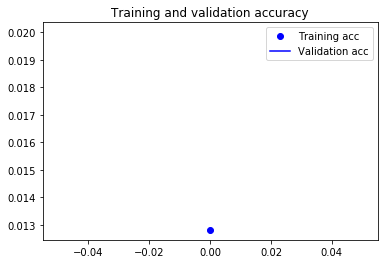

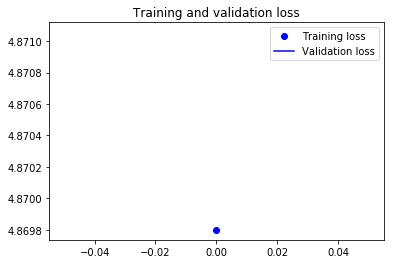

In [111]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a 
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to 
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data 
augmentation*.

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data 
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same 
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance. Let's get started with an example:

In [31]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

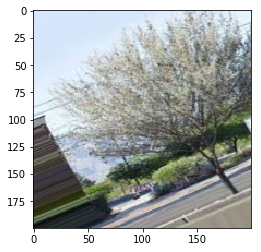

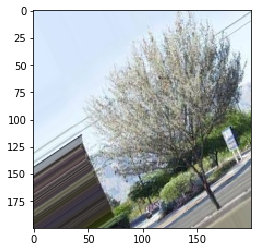

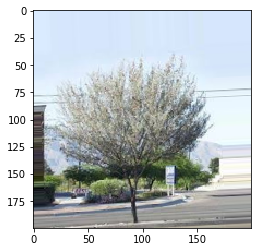

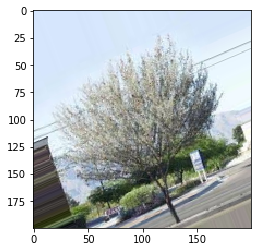

In [32]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(200, 200))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [33]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(143, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              #metrics=['categorical_accuracy']
              metrics=['accuracy'])

Let's train our network using data augmentation and dropout:

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(200, 200),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels 
        class_mode='categorical'
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(200, 200),
        batch_size=32, 
        class_mode='categorical'
        )

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=500,
      validation_data=validation_generator,
      validation_steps=50)

Found 38777 images belonging to 143 classes.
Found 3571 images belonging to 143 classes.
Epoch 1/500
100/100 [==============================] - 354s 4s/step - loss: 4.9056 - acc: 0.0066 - val_loss: 4.8854 - val_acc: 0.0106
Epoch 2/500
100/100 [==============================] - 329s 3s/step - loss: 4.8649 - acc: 0.0147 - val_loss: 4.8630 - val_acc: 0.0206
Epoch 3/500
100/100 [==============================] - 330s 3s/step - loss: 4.8548 - acc: 0.0216 - val_loss: 4.8397 - val_acc: 0.0170
Epoch 4/500
100/100 [==============================] - 329s 3s/step - loss: 4.8353 - acc: 0.0206 - val_loss: 4.8273 - val_acc: 0.0288
Epoch 5/500
100/100 [==============================] - 326s 3s/step - loss: 4.8032 - acc: 0.0256 - val_loss: 4.7710 - val_acc: 0.0302
Epoch 6/500
100/100 [==============================] - 323s 3s/step - loss: 4.7794 - acc: 0.0316 - val_loss: 4.7879 - val_acc: 0.0306
Epoch 7/500
100/100 [==============================] - 324s 3s/step - loss: 4.7520 - acc: 0.0328 - val_loss

100/100 [==============================] - 361s 4s/step - loss: 4.4623 - acc: 0.0720 - val_loss: 4.5440 - val_acc: 0.0781
Epoch 62/500
100/100 [==============================] - 364s 4s/step - loss: 4.4562 - acc: 0.0756 - val_loss: 4.5205 - val_acc: 0.0881
Epoch 63/500
100/100 [==============================] - 363s 4s/step - loss: 4.4698 - acc: 0.0769 - val_loss: 4.5134 - val_acc: 0.0844
Epoch 64/500
100/100 [==============================] - 364s 4s/step - loss: 4.4868 - acc: 0.0834 - val_loss: 4.5728 - val_acc: 0.0656
Epoch 65/500
100/100 [==============================] - 362s 4s/step - loss: 4.5057 - acc: 0.0800 - val_loss: 4.5155 - val_acc: 0.0800
Epoch 66/500
100/100 [==============================] - 363s 4s/step - loss: 4.4724 - acc: 0.0828 - val_loss: 4.6074 - val_acc: 0.0731
Epoch 67/500
100/100 [==============================] - 365s 4s/step - loss: 4.4676 - acc: 0.0803 - val_loss: 4.5196 - val_acc: 0.0775
Epoch 68/500
100/100 [==============================] - 365s 4s/step

Let's save our model -- we will be using it in the section on convnet visualization.

In [100]:
model.save('models/mitero_model_augmentation.h5')

Let's plot our results again:

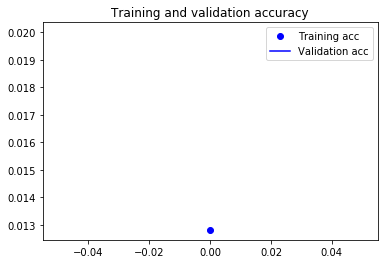

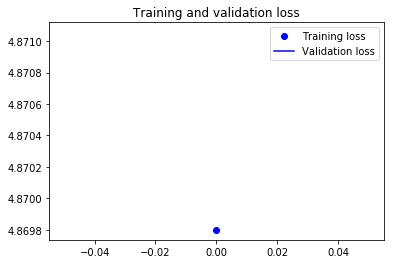

In [105]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

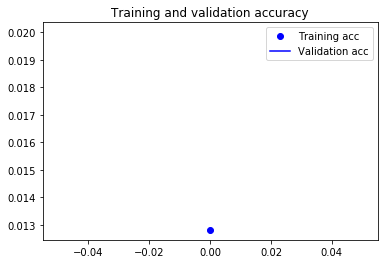

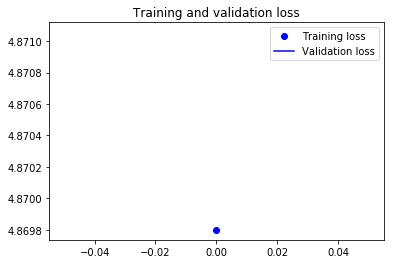

In [106]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation 
curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution 
layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove 
very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a 
next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two 
sections.

In [18]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [19]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [20]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

### Predict Images

In [27]:
from keras import models
from keras.models import load_model
#model = Sequential()
# Deletes the existing model
#del model  

# Returns a compiled model identical to the previous one
model = load_model('models/miitero_model.h5')


In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 128)       147584    
__________

In [116]:
import cv2
import numpy as np
img = cv2.imread('tress/robusta.jpeg')
y = cv2.resize(img, (200, 200 )) 
imgs = np.expand_dims(y, axis=0)

In [1]:
import cv2
import numpy as np
img = cv2.imread('tress/robusta.jpeg')
y = cv2.resize(img, (200, 200 )) 
imgs = np.expand_dims(y, axis=0)

# Plot the image.
plt.imshow(img)
plt.show()
    
preds = model.predict(imgs)
sorted_preds = []

for cls in train_generator.class_indices:
    x = preds[0][train_generator.class_indices[cls]]
    x_pred = "{:.1%}".format(x)
    sorted_preds.append([x_pred, cls])
top_4 = sorted(sorted_preds, reverse=True)[:4]
print(*top_4, sep="\n")

NameError: name 'plt' is not defined

In [161]:
def prediction (image_path):
    import cv2
    import numpy as np
    img = cv2.imread(image_path)
    y = cv2.resize(img, (200, 200 )) 
    imgs = np.expand_dims(y, axis=0)
    print('CV2 image size', imgs.size)
    # Plot the image.
    plt.imshow(img)
    plt.show()
    preds = model.predict(imgs)
    sorted_preds = []
    for cls in train_generator.class_indices:
        x = preds[0][train_generator.class_indices[cls]]
        x_pred = "{:.1%}".format(x)
        sorted_preds.append([x_pred, cls])
    top_4 = sorted(sorted_preds, reverse=True)[:4]
    print(*top_4, sep="\n")

CV2 image size 120000


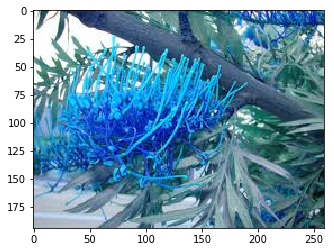

['55.9%', 'Eucalyptus_globulus']
['4.8%', 'Casuarina_equisetifolia']
['39.1%', 'Ceiba_pentandra']
['0.2%', 'Cussonia_Spicata']


In [162]:
prediction(image_path='tress/robusta.jpeg')

In [159]:
def predict (image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    input_shape = (200, 200)
    #img_resized = img.resize(input_shape, PIL.Image.LANCZOS)
    img_resized = img.resize(input_shape)
    print('PIL image size', img_resized.size)
    
    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)
    
    # Use the Mitero model to make a prediction.
    # This outputs an array with 143 numbers corresponding to
    # the classes of the ImageNet-dataset.
    preds = model.predict(img_array)
    
    # Decode the output of the Mitero model.
    sorted_preds = []
    for cls in train_generator.class_indices:
        x = preds[0][train_generator.class_indices[cls]]
        x_pred = "{:.1%}".format(x)
        sorted_preds.append([x_pred, cls])
    top_4 = sorted(sorted_preds, reverse=True)[:4]
    
    # Print the predictions.
    print(*top_4, sep="\n")


PIL image size (200, 200)


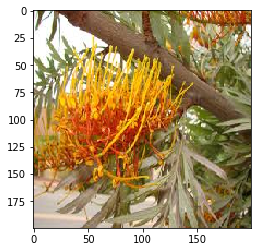

['100.0%', 'Spathodea_campanulata']
['0.0%', 'mahogany_tree']
['0.0%', 'Zanthoxylum_gilletii']
['0.0%', 'Warburgia_ugandensis']


In [160]:
predict(image_path='tress/robusta.jpeg')

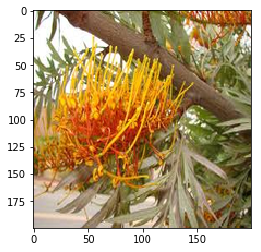

['100.0%', 'Spathodea_campanulata']
['0.0%', 'mahogany_tree']
['0.0%', 'Zanthoxylum_gilletii']
['0.0%', 'Warburgia_ugandensis']


In [129]:
predict(image_path='images/robusta.jpeg')

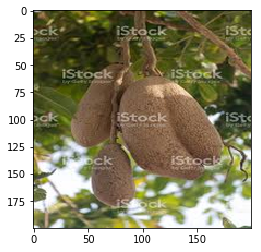

['100.0%', 'Casimiroa_edulis']
['0.0%', 'mahogany_tree']
['0.0%', 'Zanthoxylum_gilletii']
['0.0%', 'Warburgia_ugandensis']


In [143]:
predict(image_path='tress/kikuyes.jpeg')

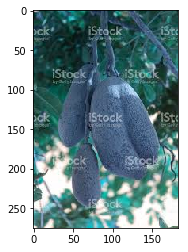

['100.0%', 'Grevillea_robusta']
['0.0%', 'mahogany_tree']
['0.0%', 'Zanthoxylum_gilletii']
['0.0%', 'Warburgia_ugandensis']


In [144]:
prediction(image_path='tress/kikuyes.jpeg')